## Ni Sample 2 layers

In [6]:
import sys
import numpy as np
import scipy.interpolate as si
import os
import scipy.optimize
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join, expanduser
#print(os.path.expanduser('~')) 
home = os.path.expanduser('~')

#sys.path.append(join(home,'helpfullscripts/'))
#sys.path.append(join(home,'Projects/helpfullscripts/'))
#import forJCM
import geo_3 as geometry
import jcm_plotting_utils as JCMgrid

jcm_root = join(home,'JCMwave/JCMsuite_6_2_1/ThirdPartySupport/Python')
jcm_root = join(home,'JCMwave/JCMsuite_6_0_10/ThirdPartySupport/Python')
sys.path.append(jcm_root)
import jcmwave




#sys.path.append(join(home,'github/XRR_workflows/calculate_n_k_from_xrr'))
#sys.path.append(join(home,'Projects/XRR_workflows/calculate_n_k_from_xrr'))
import xray_compounds as xc
import pint
unit = pint.UnitRegistry()

#import pythia.Misc as MISC

#from paramiko import SSHClient

#import json

#import pandas as pd

#import pickle 

#import xraylib

import time

In [3]:
import scipy.constants
c = scipy.constants.c #speed of light
h = scipy.constants.h #Planck
e = scipy.constants.e #elemetry charge
hc = h*c/e*1e9 #wavelenght in nm
print(hc)
def eVnm_converter(value):
    #Planck's constant (6.6261 x 10-34 J*s) and c is the speed of light (2.9979 x 108 m/s)
    return hc/value

#E (eV) = 1239.8 / l (nm)     (equation 2) 

1239.8419843320025


In [20]:
jcmwave.daemon.shutdown()
jcmwave.daemon.add_workstation(
        Hostname='localhost',
        #Login='andrle01',
        JCMROOT=jcm_root,
        Multiplicity=1,
        NThreads=12
        )

#jcmwave.set_memory_limit(max_ram=25000)
#ssh = SSHClient()
#ssh.load_system_host_keys()
#ssh.connect('aidos')
#ssh_stdin, ssh_stdout, ssh_stderr = ssh.exec_command('renice 5 -u andrle01')

[1088781160]

In [11]:
keys = {
    'fem_deg': 4,  # degree Polynom zum fitten
    'uol1': 1e-9,  # einheit in nm
    'uol': 1,
    'energy_list':np.array([280,285]), #eV
}

In [12]:
#Get optical constants from Henke and periodictable
keys['Ni_density'] = 6.5
keys['NiO2_density'] = 5


nk_Ni = np.conjugate(xc.refractive_index('Ni', keys['energy_list'] * unit.eV, density=6.5))
nk_NiO = np.conjugate(xc.refractive_index('NiO', keys['energy_list'] * unit.eV, density=5))


nk_Si3N4 = np.conjugate(xc.refractive_index('Si3N4', keys['energy_list'] * unit.eV, density=2.8))
nk_H2O = np.conjugate(xc.refractive_index('H2O', keys['energy_list'] * unit.eV, density=1))

keys['nk_Ni'] = nk_Ni
keys['nk_NiO2'] = nk_NiO
keys['nk_Si3N4'] = nk_Si3N4
keys['nk_H2O'] = nk_H2O

In [16]:


i_taken_energy = -1
energy =  keys['energy_list'] * unit.eV
wl = energy.to(unit.nm, 'sp').magnitude
keys['energy'] = energy[i_taken_energy].to(unit.keV, 'sp').magnitude
keys['pol'] = [1, 0] #1,0 s pol 0,1 p pol
keys['lambda'] = wl[i_taken_energy] * 1e-9



keys['nk'] = [ 1 + 0 * 1j, #vacuum
              nk_NiO[i_taken_energy], #oxide layer
              nk_Ni[i_taken_energy], #material of the grating
               nk_Si3N4[i_taken_energy], #nk_Si3N4, #layer on top of the substrate
               nk_H2O[i_taken_energy], #1 + 0 * 1j #nk_H2O[0], #1 + 0 * 1j #substrate nk_Si
              1 + 0 * 1j, #cont_layer
             ]


keys['name_domain'] = ['vacuum','oxide layer','grating','layer','substrate','cont']
keys_geo ={
    'pitch':200,
    'height':50,
    'cd':100,
    'swa':88,
    'thickness_oxid_etch_offset':0,
    'thickness_oxid':3,
    'thickness_oxid_Si_Si3N4': 50,
    'height_offset_substrate':8,
    'height_offset_air':5,
    'height_etch_offset':0,
    'height_C':5,
    'R':5
    }

keys.update(keys_geo)

height_cell = keys['height']+keys['height_C']+keys['thickness_oxid']+5 #+keys['thickness_oxid_Si_Si3N4']
keys['height_offset_air'] += height_cell-keys['thickness_oxid_Si_Si3N4']
keys['points_substrate'], keys['points_line_komplet'], keys['points_oxid_komplet'], keys[
        'points_cd'], keys["points_to_Si_Si3N4"], keys['points_cont_komplet'] = geometry.geometry(keys['cd'], keys['R'], keys['thickness_oxid']+keys['height_C'],
                                                                 keys['swa'], keys['pitch'], keys['height'],
                                                                 keys['height_offset_substrate'],
                                                                 keys['thickness_oxid_Si_Si3N4'],
                                                                 keys['height_etch_offset'],
                                                                 keys['thickness_oxid_etch_offset'],
                                                                 keys['height_offset_air'],height_C=keys['height_C'])

print(keys['height_C'])
p2 = keys['pitch']/2
height_liquid = keys['height']+keys['thickness_oxid']+2*keys['height_C']+10
print(height_liquid)
keys['points_substrate'] = np.array([-p2,0,p2,0,p2,height_liquid,-p2,height_liquid])


#angles = np.linspace(-120,-90,51)
keys['Theta_unique'] = np.array([0.5,45,90])


keys['slc'] = 0.7 #0.5
keys['fem_deg'] = 5




5
73


Text(0, 0.5, 'Y / nm')

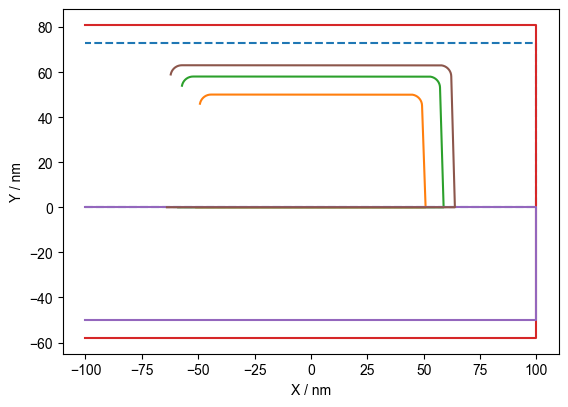

In [17]:

plt.axes().set_aspect('equal')
plt.plot(keys['points_substrate'][::2],keys['points_substrate'][1::2],'--')
plt.plot(keys['points_line_komplet'][::2],keys['points_line_komplet'][1::2],'-')
plt.plot(keys['points_oxid_komplet'][::2],keys['points_oxid_komplet'][1::2])
plt.plot(keys['points_cd'][::2],keys['points_cd'][1::2])
plt.plot(keys['points_to_Si_Si3N4'][::2],keys['points_to_Si_Si3N4'][1::2])
plt.plot(keys['points_cont_komplet'][::2],keys['points_cont_komplet'][1::2])
plt.xlabel('X / nm')
plt.ylabel('Y / nm')

Text(0, 0.5, 'Y / nm')

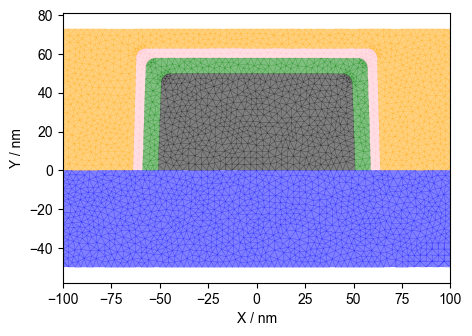

In [18]:
keys['slc'] = 5
jcmwave.geo('./_JCM_clean/', keys=keys )
figure,ax1 =plt.subplots(1,1, figsize=(5,10))
JCMgrid.plot_grid('./_JCM_clean/grid.jcm', ax= ax1 , colors = {1: 'white', 2:'green', 3: 'black', 4:'blue', 5:'orange', 6:'pink'}, alpha= 0.5 , lw = 0.2)
#jcmwave.view('./_JCMupdate/grid.jcm')
plt.xlim(-keys['pitch']/2,keys['pitch']/2)
plt.ylim(np.min(keys['points_cd'][1::2]),np.max(keys['points_cd'][1::2]))
ax1.set_aspect('equal')
plt.xlabel('X / nm')
plt.ylabel('Y / nm')
#figure.savefig('mesh_Ni_01.png',dpi=200)

In [21]:
keys['angle_of_incidence'] = keys['Theta_unique'][0] #keys['angles'][10][0] #90-keys['angles'][0][0]+keys['aoi_offset'] +180
#print(Theta_unique[30])

keys['phi'] = 90 #90 +keys['angles'][0][1]+keys['phi_offset']  #
keys['slc'] = 0.7
#keys['fem_deg'] = 4

#jcmwave.daemon.shutdown()
job_ids = jcmwave.solve('./_JCM_clean/project-field.jcmpt',  keys=keys)
#job_ids = jcmwave.solve('./_JCM_clean/project.jcmpt',  keys=keys)
#start = time.time()
results, logs = jcmwave.daemon.wait(job_ids,verbose=False)
#end = time.time()
#print(end - start)


In [45]:
print(logs)

[{'ExitCode': 0, 'Log': {'Error': '', 'Out': '\n\n\n*** Solving /global/u1/k/kandrle/github/Ni_project/_JCM_clean/project-field.jcmp on refinement level 0 ... \n\nA priori segments/wavelength (quality = 1.00e-02)\n  FEM degree  direction X  direction Y\n-------------------------------------------------\n           1          inf          inf\n           2          inf          inf\n           3          inf          inf\n           4         2.43         2.43\n           5         1.61         1.61\n           6         1.19         1.19\n           7         0.93         0.93\n           8         0.76         0.76\n           9         0.64         0.64\n          10         0.55         0.55\n  minimum seg/wavelength in grid : 1.83\n  maximum seg/wavelength in grid : 4.09\n\n  *** A priori interior domain wave propagation characteristics (vacuum wavelength = 1.414 nm):\n  \n       Compartment "Y":\n    computational domain size:   92 (wavelengths).\n    computational domain range wa

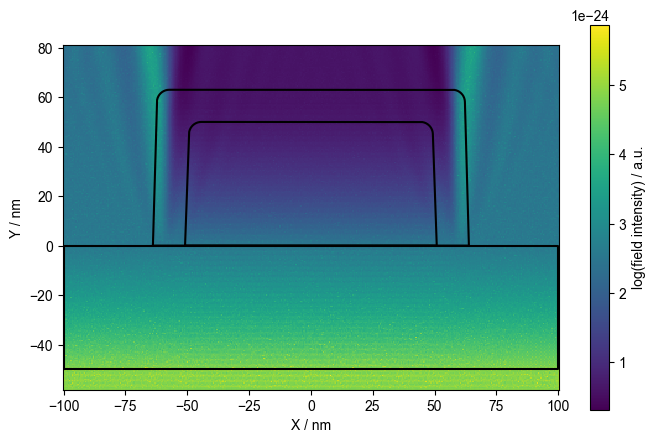

In [22]:
#jcmwave.view('./_JCMupdate/project_results/fieldbag.jcm')
result = results[0]
index_take = 1
amplitude = result[index_take]['field'][0]
intensity = (amplitude.conj()*amplitude).sum(2).real 


#intensity = np.absolute(result[4]['field'][0])

#np.shape(result[4]['X'])
np.shape(intensity)
#intensity
figure,ax1 =plt.subplots(1,1, figsize=(8,5))
plt.pcolormesh(result[index_take]['X']*1e9,result[index_take]['Y']*1e9,(intensity))
plt.xlabel('X / nm')
plt.ylabel('Y / nm')
ax1.set_aspect('equal')
plt.colorbar(label='log(field intensity) / a.u.')

x_line = np.append(keys['points_line_komplet'][::2],keys['points_line_komplet'][0])
y_line = np.append(keys['points_line_komplet'][1::2],keys['points_line_komplet'][1])
x_oxide = np.append(keys['points_cont_komplet'][::2],keys['points_cont_komplet'][0])
y_oxide = np.append(keys['points_cont_komplet'][1::2],keys['points_cont_komplet'][1])
x_mem = np.append(keys['points_to_Si_Si3N4'][::2],keys['points_to_Si_Si3N4'][0])
y_mem = np.append(keys['points_to_Si_Si3N4'][1::2],keys['points_to_Si_Si3N4'][1])
plt.plot(x_line,y_line,'k-')
plt.plot(x_oxide,y_oxide,'k-')
plt.plot(x_mem,y_mem,'k-')
figure.savefig('field_distribution_Ni_01.png',dpi=200)

(-500000000.0, 500000000.0)

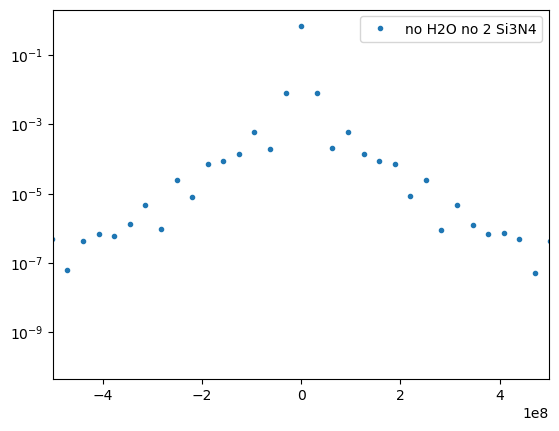

In [15]:
Kx = results[0][-1]['K'][:,0]
amplitude_x = results[0][-1]['ElectricFieldStrength'][0][:,0]
amplitude_y = results[0][-1]['ElectricFieldStrength'][0][:,1]
amplitude_z = results[0][-1]['ElectricFieldStrength'][0][:,2]
intensity_no2Si4N4 = (amplitude_x.conj()*amplitude_x).real +(amplitude_y.conj()*amplitude_y).real +(amplitude_z.conj()*amplitude_z).real 

#plt.plot(Kx,intensity,'.',label='complete cell')
#plt.plot(Kx,intensity_noH2O,'.',label='no H2O')
#plt.plot(Kx,intensity_no2Si4N4,'.',label='no 2 Si3N4')
plt.plot(Kx,intensity_no2Si4N4,'.',label='no H2O no 2 Si3N4')
plt.legend()
plt.yscale('log')
plt.xlim(-0.5e9,0.5e9)